In [1]:
import numpy as np
import os

# for deep learning:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new!
from keras.layers import Conv2DTranspose, UpSampling2D # new!
from keras.optimizers import RMSprop # new!

# for plotting:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/angel.npy \
     -O /content/quickdraw_data/full_numpy_bitmap_angel.npy

--2026-01-21 01:32:22--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/angel.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117393104 (112M) [application/octet-stream]
Saving to: ‘/content/quickdraw_data/full_numpy_bitmap_angel.npy’

/content/quickdraw_ 100%[===================>] 111.95M   113MB/s    in 1.0s    

2026-01-21 01:32:24 (113 MB/s) - ‘/content/quickdraw_data/full_numpy_bitmap_angel.npy’ saved [117393104/117393104]



In [21]:
data = np.load("/content/quickdraw_data/full_numpy_bitmap_angel.npy")
print(data.shape)  # esperado: (149736, 784)

(149736, 784)


In [23]:
data = data/255 # pra scalar pixels no range de 0 a 1
data = np.reshape(data,(data.shape[0],28,28,1)) # converte pra 28x28 matriz de pixels
img_w,img_h = data.shape[1:3]

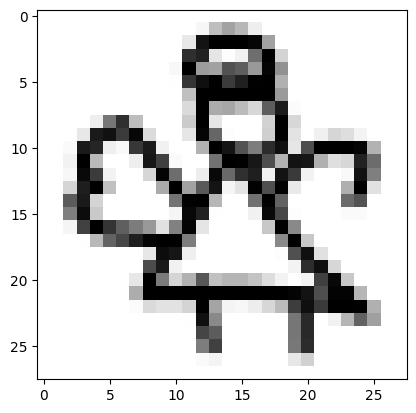

In [24]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

# Discriminator Network

In [26]:
def build_discriminator(depth=64, p=0.4):
  # Define inputs
  image = Input((img_w,img_h,1)) # 28 x 29

  # Convolutional layers
  conv1 = Conv2D(depth*1, 5, strides=2,
                 padding='same', activation='relu')(image)
  conv1 = Dropout(p)(conv1) # filter size de 5x5

  conv2 = Conv2D(depth*2, 5, strides=2,
                padding='same', activation='relu')(conv1)
  conv2 = Dropout(p)(conv2)

  conv3 = Conv2D(depth*4, 5, strides=2,
                padding='same', activation='relu')(conv2)
  conv3 = Dropout(p)(conv3)

  conv4 = Conv2D(depth*8, 5, strides=1,
                padding='same', activation='relu')(conv3)
  conv4 = Flatten()(Dropout(p)(conv4))

  # Output layer
  prediction = Dense(1, activation='sigmoid')(conv4)

  # Model definition
  model = Model(inputs=image, outputs=prediction)
  # output = só um neuronio sigmoid pq é classificaçao binaria

  return model

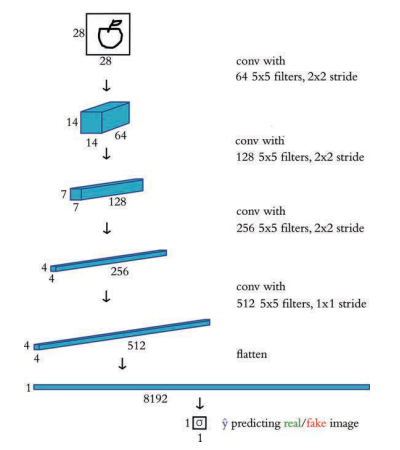

In [27]:
discriminator = build_discriminator()

In [28]:
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,311,553 (16.45 MB)

 Trainable params: 4,311,553 (16.45 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(learning_rate=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0), # preve o grad learning de passar desse valor
                      metrics=['accuracy'])
# melhor compilar com adagrad ou adam se usar a CPU

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# Generator Network

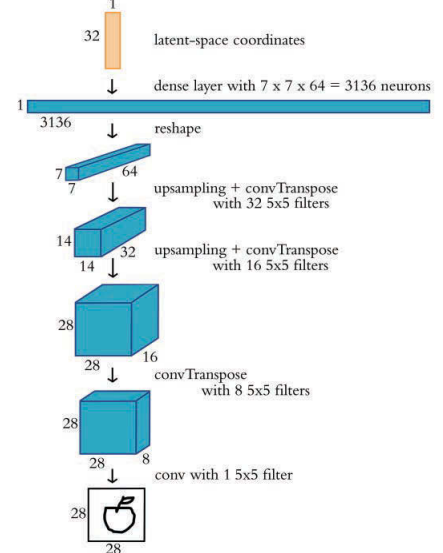

In [32]:
z_dimensions = 32

In [33]:
def build_generator(latent_dim=z_dimensions,
                    depth=64, p=0.4):

    # Define inputs
    noise = Input((latent_dim,))

    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2),
                            kernel_size=5, padding='same',
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same',
                   activation='sigmoid')(conv3)

    # Model definition
    model = Model(inputs=noise, outputs=image)

    return model


In [34]:
generator = build_generator() # PÁGINA 314

In [35]:
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3136)           │        12,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │        12,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 8)      │         3,208 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,713 (717.63 KB)

 Trainable params: 177,329 (692.69 KB)

 Non-trainable params: 6,384 (24.94 KB)